# Лаба 3

**Дедлайн**: 9 декабря

**Задача**: разобраться в описанном ниже коде, используемой/используемых моделях, ответить на указанные вопросы и сгенерировать faceswap со своей фотографией

**Описание**

Порой, вместо самостоятельного написания нейросети и ее обучения (или дообучения) приходится использовать уже готовые модели и разбираться, как они устроены - будь то код в репозитории на Github-e, Jupyter Notebook или специальная библиотека с небольшой документацией. В данном задании вам предлагается решить эту задачу - разобраться с уже готовой моделью, успешно запустить ее, залезть в сорсы и посмотреть, как крупная модель устроена изнутри.

В качестве решения лабораторной ожидается отчет в конце этого Jupyter Notebook-a с результатами генерации по вашим изображениям и ответами на следующие вопросы:

1. Где расположен код модели и кто разработчик?
2. Есть ли статья по работе модели? Если да, то в чем суть подхода авторов, как обучалась модель, какие метрики были достигнуты?
3. Состоит ли модель из нескольких частей? Если да, то из каких, что они делают и как называются в коде?
4. Как проходит процесс инференса модели для фото и видео (подробно)? Какие применяются преобразования входных и выходных данных?
5. Можно ли дообучить модель и какие для этого требуются ресурсы? Может, авторы давали советы по обучению/дообучению? 

# GHOST: Generative High-fidelity One Shot Transfer

<img src="https://drive.google.com/uc?export=view&id=1MdOWxP9CqyqmW6t9MQ6-gcfEux54zbqP">

In [1]:
#@markdown #**Check GPU and CUDA version**

!nvidia-smi

!nvcc --version

Wed May 31 19:53:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@markdown #**Clone github & download models**

!git clone https://github.com/sberbank-ai/sber-swap.git
%cd sber-swap

# load arcface
!wget -P ./arcface_model https://github.com/sberbank-ai/sber-swap/releases/download/arcface/backbone.pth
!wget -P ./arcface_model https://github.com/sberbank-ai/sber-swap/releases/download/arcface/iresnet.py

# load landmarks detector
!wget -P ./insightface_func/models/antelope https://github.com/sberbank-ai/sber-swap/releases/download/antelope/glintr100.onnx
!wget -P ./insightface_func/models/antelope https://github.com/sberbank-ai/sber-swap/releases/download/antelope/scrfd_10g_bnkps.onnx

# load model itself
!wget -P ./weights https://github.com/sberbank-ai/sber-swap/releases/download/sber-swap-v2.0/G_unet_2blocks.pth

# load super res model
!wget -P ./weights https://github.com/sberbank-ai/sber-swap/releases/download/super-res/10_net_G.pth

Cloning into 'sber-swap'...
remote: Enumerating objects: 704, done.
remote: Total 704 (delta 0), reused 0 (delta 0), pack-reused 704
Receiving objects: 100% (704/704), 93.99 MiB | 16.93 MiB/s, done.
Resolving deltas: 100% (176/176), done.
/content/sber-swap
--2023-05-31 19:53:51--  https://github.com/sberbank-ai/sber-swap/releases/download/arcface/backbone.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ai-forever/ghost/releases/download/arcface/backbone.pth [following]
--2023-05-31 19:53:52--  https://github.com/ai-forever/ghost/releases/download/arcface/backbone.pth
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-production-release-asset-2e65be/437939371/bfc1b827-8d3a-4001-863c-d6d04ffb1258?X-Amz-Algorithm=AWS4-HM

In [3]:
#@markdown #**Install required libraries**

!pip install mxnet-cu112
!pip install onnxruntime==1.12
!pip install insightface==0.2.1
!pip install kornia==0.5.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.4/499.4 MB 3.3 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 76.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00


In [5]:
#@markdown #**Preparation**

import cv2
import torch
import time
import os



from utils.inference.image_processing import crop_face, get_final_image, show_images
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement
from utils.inference.core import model_inference

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

/usr/local/lib/python3.10/dist-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/mxnet/numpy/utils.py:37: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bool = onp.bool
/usr/local/lib/python3.10/dist-packages/mxnet/numpy/fallback.py:143: DeprecationWarning: In accordance with NEP 32, the function mirr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  mirr = onp.mirr

In [6]:
#@markdown #**Initialize models**

app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
Network [LIPSPADEGenerator] was created. Total number of parameters: 72.2 million. To see the architecture, do print(network).
Load checkpoint from path:  weights/10_net_G.pth


In [9]:
source_full = cv2.imread("../Content/papich.jpeg")
# print(source_full)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
#@markdown #**Upload source image and video**

#@markdown choose not really long videos, coz it can take a lot of time otherwise  

#@markdown choose source image as a photo -- preferable a selfie of a person

target_type = 'image' #@param ["video", "image"]


source_path = '../Content/bubn.jpg' #@param {type:"string"}
target_path = '../Content/papich.jpeg' #@param {type:"string"}
# path_to_video = '/content/nggyup.mp4' #@param {type:"string"}

source_full = cv2.imread(source_path)
# OUT_VIDEO_NAME = "examples/results/result.mp4"
crop_size = 224 # don't change this


# check, if we can detect face on the source image

try:    
    source = crop_face(source_full, app, crop_size)[0]
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")

# read video
if target_type == 'image':
    target_full = cv2.imread(target_path)
    full_frames = [target_full]
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Everything is ok!


In [11]:
#@markdown #**Inference**


batch_size =  40#@param {type:"integer"}

START_TIME = time.time()

final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=batch_size)

if use_sr:
    final_frames_list = face_enhancement(final_frames_list, model)

if target_type == 'video':
  get_final_video(final_frames_list,
                  crop_frames_list,
                  full_frames,
                  tfm_array_list,
                  OUT_VIDEO_NAME,
                  fps, 
                  handler)
  
  add_audio_from_another_video(path_to_video, OUT_VIDEO_NAME, "audio")

  print(f'Full pipeline took {time.time() - START_TIME}')
  print(f"Video saved with path {OUT_VIDEO_NAME}")
else:
  result = get_final_image(final_frames_list, crop_frames_list, full_frames[0], tfm_array_list, handler)
  cv2.imwrite('examples/results/result.png', result)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
1it [00:00, 188.29it/s]
1it [00:00, 2514.57it/s]
100%|██████████| 1/1 [00:00<00:00, 9962.72it/s]
1it [00:02,  2.78s/it]
/usr/local/lib/python3.10/dist-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):
/usr/local/lib/python3.10/dist-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if spsp is not

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


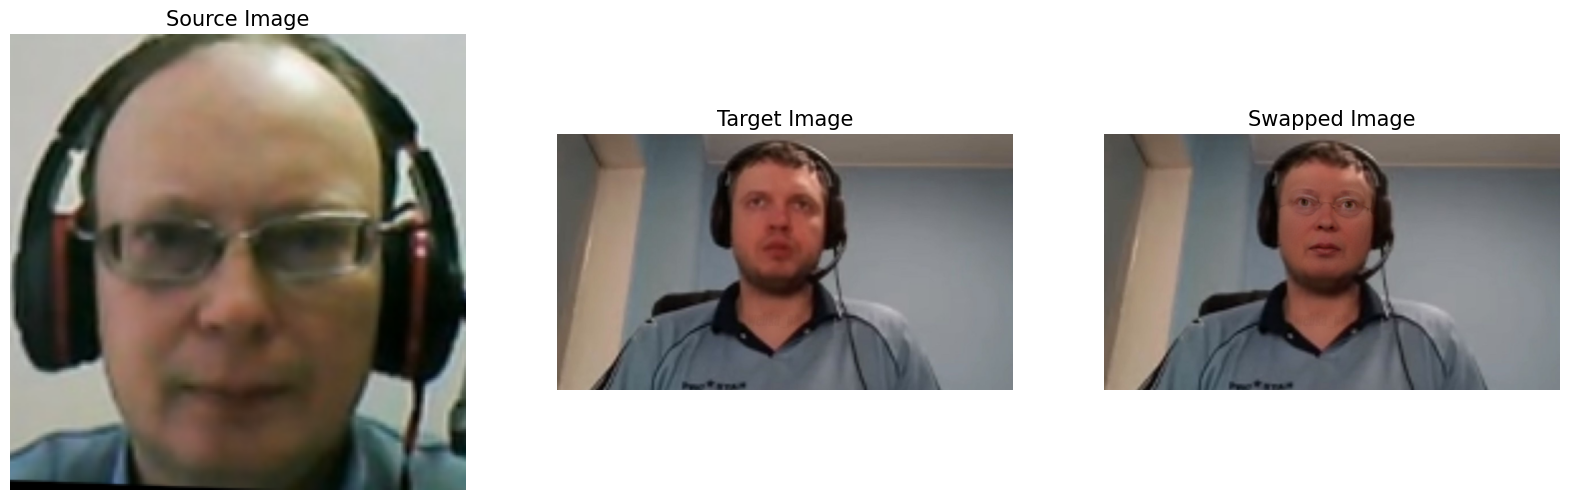

In [12]:
#@markdown #**Visualize Image to Image swap**

import matplotlib.pyplot as plt

show_images([source[0][:, :, ::-1], target_full, result], ['Source Image', 'Target Image', 'Swapped Image'], figsize=(20, 15))


In [ ]:
#@markdown #**Visualize Video Swap**

from IPython.display import HTML
from base64 import b64encode

video_file = open(OUT_VIDEO_NAME, "r+b").read()
video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"

HTML(f"""<video width={800} controls><source src="{video_url}"></video>""")